<a href="https://colab.research.google.com/github/marzier/CSC481/blob/main/GA-v9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

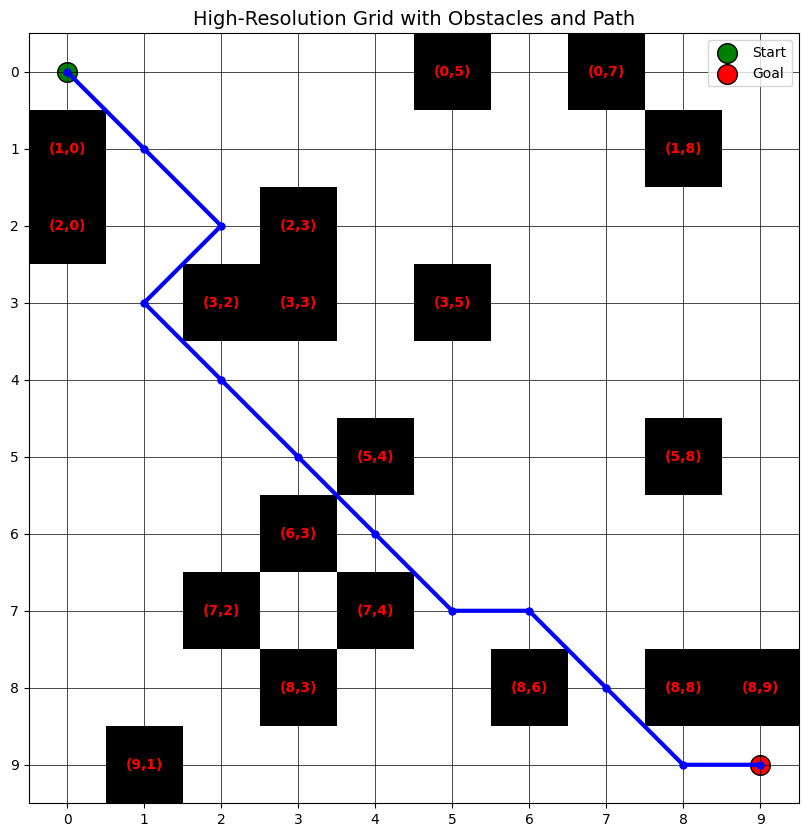


===== BEST PATH FOUND =====
[(1, 1), (2, 2), (3, 1), (4, 2), (5, 3), (6, 4), (7, 5), (7, 6), (8, 7), (9, 8), (9, 9)]

===== OBSTACLE LOCATIONS =====
{(5, 4), (8, 3), (8, 9), (0, 5), (8, 6), (1, 0), (7, 4), (3, 3), (9, 1), (8, 8), (0, 7), (1, 8), (3, 2), (3, 5), (5, 8), (2, 0), (2, 3), (7, 2), (6, 3)}

===== PATH VALIDATION =====
✅ The best path does NOT contain obstacles.


In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Constants
GRID_SIZE = 10
START = (0, 0)
GOAL = (9, 9)
NUM_OBSTACLES = 19
POP_SIZE = 50
GENS = 800
MUTATION_RATE = 0.3

# Movement options (8 directions)
MOVES = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (-1, -1), (1, -1), (-1, 1)]

# Generate random obstacles
obstacles = set()
while len(obstacles) < NUM_OBSTACLES:
    x, y = np.random.randint(0, GRID_SIZE, size=2)
    if (x, y) != START and (x, y) != GOAL:
        obstacles.add((x, y))

# Grid visualization function
def visualize_grid(path=None, title="High-Resolution Grid with Obstacles"):
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for ox, oy in obstacles:
        grid[ox, oy] = 1  # Mark obstacles

    fig, ax = plt.subplots(figsize=(10, 10))  # Increased resolution
    ax.imshow(grid, cmap="gray_r", origin="upper")

    # Add grid lines
    ax.set_xticks(np.arange(0, GRID_SIZE, 1))
    ax.set_yticks(np.arange(0, GRID_SIZE, 1))
    ax.set_xticklabels(np.arange(0, GRID_SIZE, 1))
    ax.set_yticklabels(np.arange(0, GRID_SIZE, 1))
    ax.grid(which="both", color="black", linestyle='-', linewidth=0.5)

    if path:
        ax.plot(*zip(*([(START[1], START[0])] + [(p[1], p[0]) for p in path])), marker="o", color="blue", markersize=5, linestyle="-", linewidth=3)

    for ox, oy in obstacles:
        ax.text(oy, ox, f"({ox},{oy})", ha='center', va='center', color='red', fontsize=10, fontweight='bold')

    ax.scatter(*START, color="green", label="Start", s=200, edgecolors="black")
    ax.scatter(*GOAL, color="red", label="Goal", s=200, edgecolors="black")
    ax.set_title(title, fontsize=14)
    ax.legend()
    plt.show()

# Heuristic-guided path initialization
def generate_path():
    """ Generates a path biased toward the goal while avoiding obstacles. """
    path = []
    pos = START
    while pos != GOAL and len(path) < 30:
        valid_moves = [(m[0] + pos[0], m[1] + pos[1]) for m in MOVES if
                       0 <= m[0] + pos[0] < GRID_SIZE and
                       0 <= m[1] + pos[1] < GRID_SIZE and
                       (m[0] + pos[0], m[1] + pos[1]) not in obstacles]

        if not valid_moves:
            break

        # Choose the move that brings the position closest to the goal
        move = min(valid_moves, key=lambda p: np.linalg.norm(np.array(p) - np.array(GOAL)))
        path.append(move)
        pos = move

    return path

# Fitness function
def fitness(path):
    pos = START
    length = len(path)
    reached_goal = False

    for pos in path:
        if pos in obstacles or not (0 <= pos[0] < GRID_SIZE and 0 <= pos[1] < GRID_SIZE):
            return -500  # Strong penalty for invalid paths
        if pos == GOAL:
            reached_goal = True
            break

    distance_to_goal = np.linalg.norm(np.array(pos) - np.array(GOAL))
    fitness_score = 1 / (1 + distance_to_goal + length)

    if reached_goal:
        fitness_score += 100  # Large reward for reaching goal

    return fitness_score

# Crossover function
def crossover(parent1, parent2):
    """ Combines two paths by taking first half from one and second half from the other. """
    split = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child = parent1[:split] + parent2[split:]
    return child

# Mutation function with improved validity
def mutate(path):
    """ Mutates a path by swapping or modifying moves. """
    if random.random() < MUTATION_RATE and path:
        idx = random.randint(0, len(path) - 1)
        valid_moves = [(m[0] + path[idx][0], m[1] + path[idx][1]) for m in MOVES if
                       0 <= m[0] + path[idx][0] < GRID_SIZE and
                       0 <= m[1] + path[idx][1] < GRID_SIZE and
                       (m[0] + path[idx][0], m[1] + path[idx][1]) not in obstacles]
        if valid_moves:
            path[idx] = random.choice(valid_moves)
    return path

# Selection: Tournament selection
def select(population):
    """ Selects best path from a small tournament of random individuals. """
    tournament = random.sample(population, min(5, len(population)))
    return max(tournament, key=fitness)

# Run Genetic Algorithm
population = [generate_path() for _ in range(POP_SIZE)]
best_path = None

for gen in range(GENS):
    new_population = []

    # Generate offspring via crossover and mutation
    for _ in range(POP_SIZE // 2):
        parent1, parent2 = select(population), select(population)
        child = crossover(parent1, parent2)
        child = mutate(child)
        new_population.extend([child, parent1])  # Keep diversity

    population = new_population
    best_path = max(population, key=fitness)

    # Early stopping if goal is reached
    if fitness(best_path) > 100:
        break

# Visualize the best path found
visualize_grid(best_path, "High-Resolution Grid with Obstacles and Path")

# Print best path
print("\n===== BEST PATH FOUND =====")
print(best_path)

# Print obstacle locations
print("\n===== OBSTACLE LOCATIONS =====")
print(obstacles)

# Validate if path contains obstacles
path_crosses_obstacles = any(pos in obstacles for pos in best_path)
print("\n===== PATH VALIDATION =====")
if path_crosses_obstacles:
    print("⚠️ The best path contains obstacles!")
else:
    print("✅ The best path does NOT contain obstacles.")


so the problem was with the diagram. not the path-planning.
all i had to do was flip the coordiates.



